In [1]:
# add the following code snippet to the JavaScript console of the Colab browser window to stop Google 
# Colab from disconnecting
# function ClickConnect() {
#   console.log('Working')
#   document
#     .querySelector('#top-toolbar > colab-connect-button')
#     .shadowRoot.querySelector('#connect')
#     .click()
# }
# setInterval(ClickConnect, 60000)

In [2]:
%%capture
!git clone https://github.com/chloeh13q/ISIC-skin-lesion

In [3]:
%%capture
%%bash
cd ISIC-skin-lesion/
mkdir data; cd data
# get training data
wget https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/train.zip && unzip train.zip; rm train.zip
# get validation data
wget https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/valid.zip && unzip valid.zip; rm valid.zip
# get test data
wget https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/test.zip && unzip test.zip; rm test.zip

In [4]:
import os
os.chdir('ISIC-skin-lesion/')
os.getcwd()

'/content/ISIC-skin-lesion'

In [5]:
import cv2
import matplotlib.pyplot as plt
import torch
import numpy as np
import re

%matplotlib inline

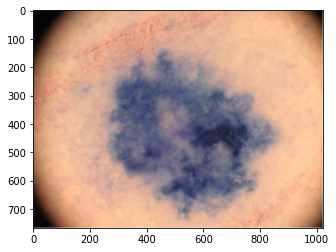

In [6]:
# load and display a sample image
img_path = 'data/train/melanoma/ISIC_0000002.jpg'
img = cv2.imread(img_path)
plt.imshow(img)
plt.show()

In [7]:
import torchvision
from torchvision import datasets
from torchvision import transforms

In [8]:
def get_dataloader(batch_size, num_workers, image_size, transform, data_dir):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param transform: Set of transformations performed on input data
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
      
    image_folder = datasets.ImageFolder(data_dir, transform=transform)
    data_loader = torch.utils.data.DataLoader(image_folder, num_workers=num_workers, 
                                              batch_size=batch_size, shuffle=True)

    return data_loader

In [119]:
train_dir = './data/train/'
valid_dir = './data/valid/'
test_dir = './data/test/'

batch_size = 64
num_workers = 1
image_size = 256

transform = transforms.Compose([transforms.Resize((image_size, image_size)),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406],
                                                      [0.229, 0.224, 0.225])])

data_loader = {'train': get_dataloader(batch_size, num_workers, image_size, train_dir),
               'valid': get_dataloader(batch_size, num_workers, image_size, valid_dir),
               'test': get_dataloader(batch_size, num_workers, image_size, test_dir)}

In [88]:
# define dictionary to map np label back to class label
classes = [d.name for d in os.scandir(train_dir) if d.is_dir()]
classes.sort()
idx_to_class = {i: cls_name for i, cls_name in enumerate(classes)}

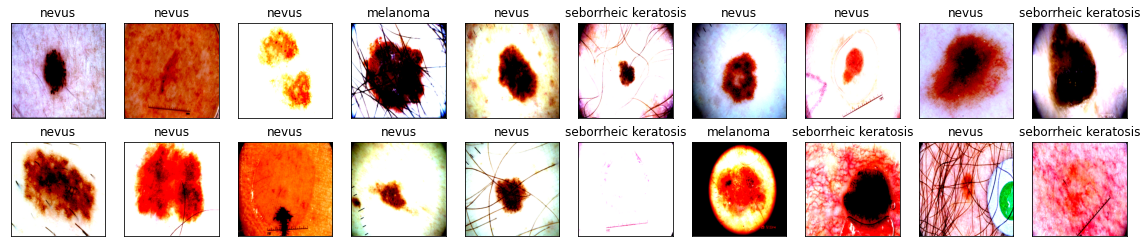

In [11]:
# display 20 images from the training set dataloader
def imshow(img):
  npimg = img.numpy()
  npimg = np.transpose(npimg, (1, 2, 0))
  npimg = np.clip(npimg, 0, 1)
  plt.imshow(npimg)

dataiter = iter(data_loader['train'])
images, labels = dataiter.next()

fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    label = re.sub('_', ' ', idx_to_class[labels.numpy()[idx]])
    ax.set_title(label)
    imshow(images[idx])

In [126]:
import torch.nn as nn
import torch.nn.functional as F

train_on_cuda = torch.cuda.is_available()

class Model(nn.Module):
  def __init__(self):
    super(Model, self).__init__()

    # define convolutional layers
    self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
    self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
    self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
    self.conv4 = nn.Conv2d(64, 128, 3, padding=1)

    # define maxpooling layer
    self.pool = nn.MaxPool2d(2, 2)

    # define fully-connected layers
    self.fc1 = nn.Linear(128*16*16, 4096)
    self.fc2 = nn.Linear(4096, 256)
    self.fc3 = nn.Linear(256, 3)

    # define dropout layer
    self.dropout = nn.Dropout(0.25)

  def forward(self, x, prob=False):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.pool(F.relu(self.conv3(x)))
    x = self.pool(F.relu(self.conv4(x)))
    x = x.view(-1, 128*16*16)
    x = self.dropout(x)
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    if prob == True:
      x = F.softmax(x, dim=1)
    return x

model = Model()
if train_on_cuda:
  print('Train on GPU')
  model = model.cuda()
else:
  print('Train on CPU')

Train on GPU


In [127]:
print(model)

Model(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=32768, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=3, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


In [14]:
import torch.optim as optim

learning_rate = 0.005
gamma = 0.5

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=gamma)

In [15]:
def train(n_epochs, loaders, model, optimizer, criterion, train_on_cuda, save_path):
  """returns trained model"""
  min_valid_loss = np.Inf

  for epoch in range(1, n_epochs+1):
    train_loss = 0.0
    valid_loss = 0.0

    # set model to training mode
    model.train()
    for batch_idx, (data, target) in enumerate(data_loader['train']):

      # move data to GPU if available
      if train_on_cuda:
        data, target = data.cuda(), target.cuda()
      
      optimizer.zero_grad()
      output = model(data)
      loss = criterion(output, target)
      loss.backward()
      optimizer.step()
      train_loss += ((1 / (batch_idx + 1)) * (loss.data - train_loss))

    # set model to evaluation mode
    model.eval()
    for batch_idx, (data, target) in enumerate(data_loader['valid']):

      # move data to GPU if available
      if train_on_cuda:
        data, target = data.cuda(), target.cuda()

      with torch.no_grad():
        output = model(data)
        loss = criterion(output, target)
        valid_loss += ((1 / (batch_idx + 1)) * (loss.data - valid_loss))

    print('Epoch: ', epoch, '; LR: ', scheduler.get_last_lr())
    print('Training loss: {:.6f} \tValidation loss: {:.6f}'.format(train_loss, valid_loss))

    # update optimizer learning rate
    scheduler.step()

    # if new valid_loss < current min_valid_loss, update min_valid_loss and save model
    if valid_loss < min_valid_loss:
      min_valid_loss = valid_loss
      torch.save(model.state_dict(), save_path)
      print('Model saved...')

  return model

In [16]:
n_epochs = 25
model = train(n_epochs, data_loader, model, optimizer, criterion, train_on_cuda, 'model.pt')

Epoch:  1 ; LR:  [0.005]
Training loss: 4.669033 	Validation loss: 1.029183
Model saved...
Epoch:  2 ; LR:  [0.0045000000000000005]
Training loss: 0.832913 	Validation loss: 1.040235
Epoch:  3 ; LR:  [0.004050000000000001]
Training loss: 0.798121 	Validation loss: 0.988856
Model saved...
Epoch:  4 ; LR:  [0.0036450000000000007]
Training loss: 0.773823 	Validation loss: 1.042330
Epoch:  5 ; LR:  [0.003280500000000001]
Training loss: 0.794825 	Validation loss: 0.918952
Model saved...
Epoch:  6 ; LR:  [0.002952450000000001]
Training loss: 0.742429 	Validation loss: 0.846053
Model saved...
Epoch:  7 ; LR:  [0.002657205000000001]
Training loss: 0.718466 	Validation loss: 0.873640
Epoch:  8 ; LR:  [0.002391484500000001]
Training loss: 0.686425 	Validation loss: 0.777364
Model saved...
Epoch:  9 ; LR:  [0.002152336050000001]
Training loss: 0.693248 	Validation loss: 0.810684
Epoch:  10 ; LR:  [0.001937102445000001]
Training loss: 0.644568 	Validation loss: 0.760295
Model saved...
Epoch:  11 ;

KeyboardInterrupt: ignored

In [19]:
def test(data_loader, model, optimizer, criterion, train_on_cuda):

  test_loss = 0.0
  correct = 0
  total = 0

  model.eval()

  with torch.no_grad():
    for batch_idx, (data, target) in enumerate(data_loader['test']):
      # move data to GPU if available
      if train_on_cuda:
        data, target = data.cuda(), target.cuda()

      output = model(data)
      loss = criterion(output, target)
      test_loss += ((1 / (batch_idx + 1)) * (loss.data - test_loss))

      pred = output.data.max(1, keepdim=True)[1]
      correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
      total += data.size(0)

    print('Test loss: {:.6f}\n'.format(test_loss))
    print('Test accuracy: %2d%% (%2d/%2d)' % (100. * correct / total, correct, total))

In [20]:
# reload saved model
model.load_state_dict(torch.load('model.pt'))

test(data_loader, model, optimizer, criterion, train_on_cuda)

Test loss: 0.774941

Test accuracy: 65% (390/600)


In [149]:
class ImageFolderWithPath(datasets.ImageFolder):
    """Custom dataset that includes image paths. Extends torchvision.datasets.ImageFolder"""

    # override the __getitem__ method that dataloader calls
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPath, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

test_imagefolder = ImageFolderWithPath(test_dir, transform=transform)
test_loader = torch.utils.data.DataLoader(test_imagefolder, num_workers=num_workers, 
                                          batch_size=batch_size, shuffle=True)

In [145]:
def dataset_with_indices(cls):
  """
  Modifies the given Dataset class to return a tuple data, target, index
  instead of just data, target.
  """
  def __getitem__(self, index):
    data, target = cls.__getitem__(self, index)
    return data, target, index

  return type(cls.__name__, (cls,), {
    '__getitem__': __getitem__,
  })

test_imagefolder_with_indices = dataset_with_indices(datasets.ImageFolder)
test_imagefolder = test_imagefolder_with_indices(test_dir, transform=transform)
test_loader = torch.utils.data.DataLoader(test_imagefolder, num_workers=num_workers, 
                                          batch_size=batch_size, shuffle=True)

In [129]:
print(idx_to_class)

def get_key(idx_to_class, label):
  """Given index, retrieve class label"""
  for key, value in idx_to_class.items():
    if value == label:
      return key

{0: 'melanoma', 1: 'nevus', 2: 'seborrheic_keratosis'}


In [154]:
import csv

all_filenames = []
task_1 = []
task_2 = []

model.eval()
with torch.no_grad():
  for batch_idx, (data, target, index) in enumerate(test_loader, 0):
    if train_on_cuda:
      data, target = data.cuda(), target.cuda()

    output = model(data, prob=True) # transform outputs to probabilities
    melanoma_idx, sk_idx = get_key(idx_to_class, 'melanoma'), get_key(idx_to_class, 'seborrheic_keratosis')
    melanoma_preds = list(output.data.cpu().numpy()[:, melanoma_idx])
    sk_preds = list(output.data.cpu().numpy()[:, sk_idx])
    
    # predictions = list(torch.max(output.data, 1)[1].cpu().numpy())
    # filenames = [test_loader.dataset.samples[i] for i in list(index)]
    filenames = [re.sub('\.\/', '',i[0].strip('\'')) for i in list(index)]
    for filename, mpred, skpred in zip(filenames, melanoma_preds, sk_preds):
      all_filenames.append(filename)
      task_1.append(mpred)
      task_2.append(skpred)

zipped_out = zip(all_filenames, task_1, task_2)
zipped_out = sorted(zipped_out)

with open('predictions.csv', 'w') as outfile:
  outfile.write('Id,task_1,task_2\n')
  for row in zipped_out:
    outfile.write('{},{:.6f},{:.6f}\n'.format(*row))

In [153]:
print(index)

('./data/test/nevus/ISIC_0015939.jpg', './data/test/nevus/ISIC_0016003.jpg', './data/test/nevus/ISIC_0014961.jpg', './data/test/nevus/ISIC_0014787.jpg', './data/test/nevus/ISIC_0015390.jpg', './data/test/melanoma/ISIC_0015071.jpg', './data/test/melanoma/ISIC_0013988.jpg', './data/test/seborrheic_keratosis/ISIC_0014503.jpg', './data/test/seborrheic_keratosis/ISIC_0014409.jpg', './data/test/melanoma/ISIC_0013739.jpg', './data/test/nevus/ISIC_0014944.jpg', './data/test/melanoma/ISIC_0014336.jpg', './data/test/nevus/ISIC_0015481.jpg', './data/test/nevus/ISIC_0015972.jpg', './data/test/melanoma/ISIC_0013987.jpg', './data/test/nevus/ISIC_0016053.jpg', './data/test/nevus/ISIC_0016006.jpg', './data/test/nevus/ISIC_0014942.jpg', './data/test/melanoma/ISIC_0013459.jpg', './data/test/nevus/ISIC_0016022.jpg', './data/test/nevus/ISIC_0013966.jpg', './data/test/nevus/ISIC_0016052.jpg', './data/test/seborrheic_keratosis/ISIC_0012387.jpg', './data/test/nevus/ISIC_0015436.jpg', './data/test/nevus/ISIC_

In [141]:
print(len(next(iter(test_loader))[0]))

64


In [143]:
print(data.shape)

torch.Size([24, 3, 256, 256])


GroundTruth:  melanoma nevus nevus nevus seborrheic_keratosis melanoma melanoma nevus nevus melanoma melanoma nevus seborrheic_keratosis melanoma nevus nevus melanoma melanoma melanoma nevus


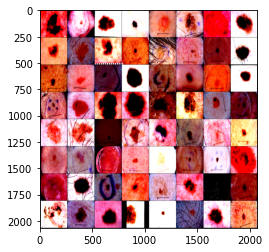

In [125]:
dataiter = iter(data_loader['test'])
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % idx_to_class[labels.numpy()[j]] for j in range(64)))

# fig = plt.figure(figsize=(20, 4))
# plot_size=20
# for idx in np.arange(plot_size):
#     ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
#     label = re.sub('_', ' ', idx_to_class[labels.numpy()[idx]]) + 
#     ax.set_title(label)
#     imshow(images[idx])